# Inspecting the Results of the Arcelik Survey Round 1

In [15]:
import os
import pickle

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
RESULTS_DICT_PATH = os.path.abspath("./survey_results_processed/fused_results.pkl")
RECIPES_WITH_ANSWERS_PATH = os.path.abspath("./survey_results_processed/survey_samples_with_answers.pkl")

#### Load Data

In [3]:
with open(RESULTS_DICT_PATH, "rb") as results_dict_file:
    results = pickle.load(results_dict_file)

with open (RECIPES_WITH_ANSWERS_PATH, "rb") as recipes_with_answers_file:
    recipes_with_answers = pickle.load(recipes_with_answers_file)

In [4]:
print(list(results.items())[0])

(0, {'individual_responses': {'fit': [1, 1, 1, 1, 1], 'tastechange': [0, 1, 0, 1, 0], 'nutruientschange': [0], 'processchange': [0, 0, 0, 0, 0], 'categorychange': [1, 0, 0, 0, 0], 'mainingr': [], 'selection': ['Pork belly', 'Pork belly', 'Pork belly', 'Pork belly', 'Pork loin'], 'usersuggestion': []}, 'consensual_answers': {'fit': 1, 'tastechange': 0, 'nutruientschange': None, 'processchange': 0, 'categorychange': 0, 'mainingr': [], 'selection': 'Pork belly', 'usersuggestion': []}})


In [5]:
print(list(results.items())[2][1]["consensual_answers"])

{'fit': 1, 'tastechange': 1, 'nutruientschange': None, 'processchange': 0, 'categorychange': 0, 'mainingr': [], 'selection': 'Ground beef', 'usersuggestion': ['ground goat']}


In [6]:
for _, result in list(results.items()):
    consensual_answers = result["consensual_answers"]
    if consensual_answers["selection"] == "None":
        print(consensual_answers)
        break

In [7]:
def get_numbers_for_consensus(results, question):
    no_consensus = 0
    consensus_is_yes = 0
    conseneus_is_no = 0
    errors = 0
    avg_number_of_responses = 0
    fewer_than_2_responses = 0
    avg_positive_to_negative_rate = 0
    avg_negative_to_positive_quotient = 0

    for result in list(results.items()):
        individual_answers = result[1]["individual_responses"][question]
        consensual_answers = result[1]["consensual_answers"][question]

        avg_number_of_responses += len(individual_answers)
        if len(individual_answers) < 1:
            fewer_than_2_responses += 1

        if len(individual_answers) > 0:
            avg_negative_to_positive_quotient += 1
            n_negative_ansers = len([answer for answer in individual_answers if answer == 0])
            n_positive_answers = len([answer for answer in individual_answers if answer == 1])
            if n_negative_ansers == 0:
                avg_positive_to_negative_rate += 1 # we can assume all answers must be positive if there is no negative answer, because we already checked the number of answer such not both nor negative can be cnt 0
            else:
                avg_positive_to_negative_rate += (n_positive_answers / n_negative_ansers) / len(individual_answers)

        if consensual_answers is None:
            no_consensus += 1
        elif consensual_answers == 1:
            consensus_is_yes += 1
        elif consensual_answers == 0:
            conseneus_is_no += 1
        else:
            errors += 1

    avg_number_of_responses = avg_number_of_responses / len(list(results.items()))
    if avg_negative_to_positive_quotient > 0:
        avg_positive_to_negative_rate = avg_positive_to_negative_rate / avg_negative_to_positive_quotient

    return no_consensus, consensus_is_yes, conseneus_is_no, errors, avg_number_of_responses, fewer_than_2_responses, avg_positive_to_negative_rate

## Q1: Does the suggested substitution fit the recipe?

In [8]:

question = "fit"

no_consensus, consensus_is_yes, conseneus_is_no, errors, avg_number_of_responses, fewer_than_2_responses, avg_positive_to_negative_rate = get_numbers_for_consensus(results, question)

q1 = [no_consensus, consensus_is_yes, conseneus_is_no, errors, avg_number_of_responses, fewer_than_2_responses, avg_positive_to_negative_rate]

print(f"nr of answers without consens: {no_consensus}")
print(f"nr of answers where consens was yes: {consensus_is_yes}")
print(f"nr of answers where consens was no: {conseneus_is_no}")
print(f"nr of error cases: {errors}")
print(f"on average, there were {avg_number_of_responses} responses per question")
print(f"nr of questions with fewer than 2 answers: {fewer_than_2_responses}")
print(f"on average, the rate of positive responses to negative responses was: {avg_positive_to_negative_rate}")

nr of answers without consens: 38
nr of answers where consens was yes: 434
nr of answers where consens was no: 29
nr of error cases: 0
on average, there were 3.8962075848303392 responses per question
nr of questions with fewer than 2 answers: 1
on average, the rate of positive responses to negative responses was: 0.8275999999999997


## Q2: Does the suggested substitution constitute a major taste change?

In [9]:
question = "tastechange"

no_consensus, consensus_is_yes, conseneus_is_no, errors, avg_number_of_responses, fewer_than_2_responses, avg_positive_to_negative_rate = get_numbers_for_consensus(results, question)

q2 = [no_consensus, consensus_is_yes, conseneus_is_no, errors, avg_number_of_responses, fewer_than_2_responses, avg_positive_to_negative_rate]

print(f"nr of answers without consens: {no_consensus}")
print(f"nr of answers where consens was yes: {consensus_is_yes}")
print(f"nr of answers where consens was no: {conseneus_is_no}")
print(f"nr of error cases: {errors}")
print(f"on average, there were {avg_number_of_responses} responses per question")
print(f"nr of questions with fewer than 2 answers: {fewer_than_2_responses}")
print(f"on average, the rate of positive responses to negative responses was: {avg_positive_to_negative_rate}")

nr of answers without consens: 94
nr of answers where consens was yes: 383
nr of answers where consens was no: 24
nr of error cases: 0
on average, there were 3.8922155688622753 responses per question
nr of questions with fewer than 2 answers: 1
on average, the rate of positive responses to negative responses was: 0.7125666666666663


## Q3: Does the suggested substitution constitute a change in the nutritional profile of the recipe?

In [10]:
question = "nutruientschange"

no_consensus, consensus_is_yes, conseneus_is_no, errors, avg_number_of_responses, fewer_than_2_responses, avg_positive_to_negative_rate = get_numbers_for_consensus(results, question)

q3 = [no_consensus, consensus_is_yes, conseneus_is_no, errors, avg_number_of_responses, fewer_than_2_responses, avg_positive_to_negative_rate]

print(f"nr of answers without consens: {no_consensus}")
print(f"nr of answers where consens was yes: {consensus_is_yes}")
print(f"nr of answers where consens was no: {conseneus_is_no}")
print(f"nr of error cases: {errors}")
print(f"on average, there were {avg_number_of_responses} responses per question")
print(f"nr of questions with fewer than 2 answers: {fewer_than_2_responses}")
print(f"on average, the rate of positive responses to negative responses was: {avg_positive_to_negative_rate}")

nr of answers without consens: 472
nr of answers where consens was yes: 8
nr of answers where consens was no: 21
nr of error cases: 0
on average, there were 0.9660678642714571 responses per question
nr of questions with fewer than 2 answers: 65
on average, the rate of positive responses to negative responses was: 0.41456422018348615


## Q4: Does the suggested substitution require a major change in the cooking instructions?

In [11]:
question = "processchange"

no_consensus, consensus_is_yes, conseneus_is_no, errors, avg_number_of_responses, fewer_than_2_responses, avg_positive_to_negative_rate = get_numbers_for_consensus(results, question)

q4 = [no_consensus, consensus_is_yes, conseneus_is_no, errors, avg_number_of_responses, fewer_than_2_responses, avg_positive_to_negative_rate]

print(f"nr of answers without consens: {no_consensus}")
print(f"nr of answers where consens was yes: {consensus_is_yes}")
print(f"nr of answers where consens was no: {conseneus_is_no}")
print(f"nr of error cases: {errors}")
print(f"on average, there were {avg_number_of_responses} responses per question")
print(f"nr of questions with fewer than 2 answers: {fewer_than_2_responses}")
print(f"on average, the rate of positive responses to negative responses was: {avg_positive_to_negative_rate}")

nr of answers without consens: 67
nr of answers where consens was yes: 89
nr of answers where consens was no: 345
nr of error cases: 0
on average, there were 3.8902195608782435 responses per question
nr of questions with fewer than 2 answers: 1
on average, the rate of positive responses to negative responses was: 0.19993333333333305


## Q5: Does the suggested substitution constitute a change in the food category (e.g. making the recipe vegetarian)?

In [12]:
question = "categorychange"

no_consensus, consensus_is_yes, conseneus_is_no, errors, avg_number_of_responses, fewer_than_2_responses, avg_positive_to_negative_rate = get_numbers_for_consensus(results, question)

q5 = [no_consensus, consensus_is_yes, conseneus_is_no, errors, avg_number_of_responses, fewer_than_2_responses, avg_positive_to_negative_rate]

print(f"nr of answers without consens: {no_consensus}")
print(f"nr of answers where consens was yes: {consensus_is_yes}")
print(f"nr of answers where consens was no: {conseneus_is_no}")
print(f"nr of error cases: {errors}")
print(f"on average, there were {avg_number_of_responses} responses per question")
print(f"nr of questions with fewer than 2 answers: {fewer_than_2_responses}")
print(f"on average, the rate of positive responses to negative responses was: {avg_positive_to_negative_rate}")

nr of answers without consens: 60
nr of answers where consens was yes: 80
nr of answers where consens was no: 361
nr of error cases: 0
on average, there were 3.8602794411177643 responses per question
nr of questions with fewer than 2 answers: 1
on average, the rate of positive responses to negative responses was: 0.1889666666666666


## Q6: Is __ the main ingredient?

## Q7: Which is the best substitution?

In [13]:
question = "selection"

no_consensus = 0
ingredient_consensus = 0
other_consensus = 0
for result in list(results.items()):
    consensual_answers = result[1]["consensual_answers"]
    fit_answer = consensual_answers[question]
    if fit_answer == "other":
        other_consensus += 1
    elif fit_answer is None:
        no_consensus += 1
    else:
        ingredient_consensus += 1

print(f"nr of answers without consens: {no_consensus}")
print(f"nr of answers where consens was 'other': {other_consensus}")
print(f"nr of answers where consens was a specific ingredient: {ingredient_consensus}")

nr of answers without consens: 239
nr of answers where consens was 'other': 0
nr of answers where consens was a specific ingredient: 262


## q8: If none of the suggested ingredients were good, which alternative do you suggest?

## Summary

[Text(0.5, 0, 'no consens'),
 Text(1.5, 0, 'cons. pos.'),
 Text(2.5, 0, 'cons. neg.'),
 Text(3.5, 0, 'nr q with nr. responses<=1')]

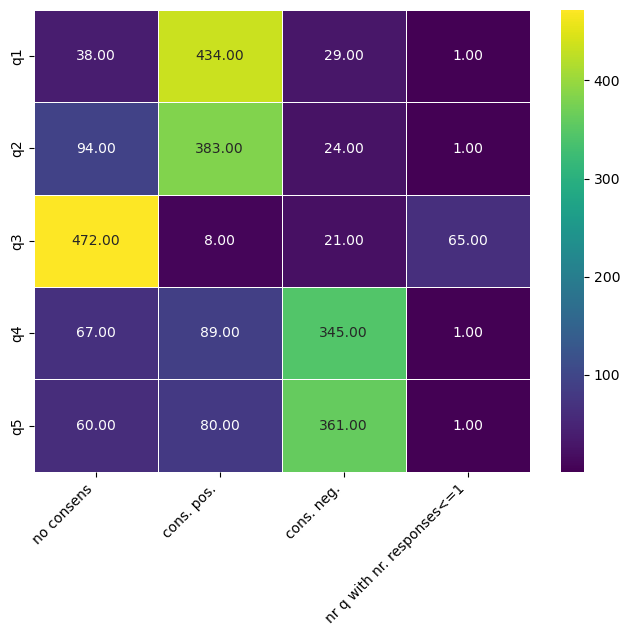

In [35]:
df_q_1_to_5 = pd.DataFrame([q1, q2, q3, q4, q5], index = ["q1", "q2", "q3", "q4", "q5"], columns = ["no consens", "cons. pos.", "cons. neg.", "errors", "avg. nr. responses", "nr q with nr. responses<=1", "avg. pos.-neg. rate"])
# print(df_q_1_to_5.head(2))
# print(df_q_1_to_5.shape)

df_q_1_to_5_a = df_q_1_to_5.iloc[:, [0,1,2,5]]
df_q_1_to_5_b = df_q_1_to_5.iloc[:, [4]]
df_q_1_to_5_c = df_q_1_to_5.iloc[:, [6]]

plt.figure(figsize=(8, 6))
heatmap = sns.heatmap(df_q_1_to_5_a, cmap='viridis', annot=True, fmt='.2f', linewidths=.5)
heatmap.set_xticklabels(heatmap.get_xticklabels(), rotation=45, ha='right')

[Text(0.5, 0, 'avg. nr. responses')]

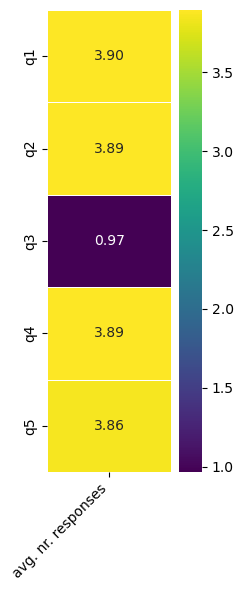

In [39]:
plt.figure(figsize=(2, 6))
heatmap = sns.heatmap(df_q_1_to_5_b, cmap='viridis', annot=True, fmt='.2f', linewidths=.5)
heatmap.set_xticklabels(heatmap.get_xticklabels(), rotation=45, ha='right')

[Text(0.5, 0, 'avg. pos.-neg. rate')]

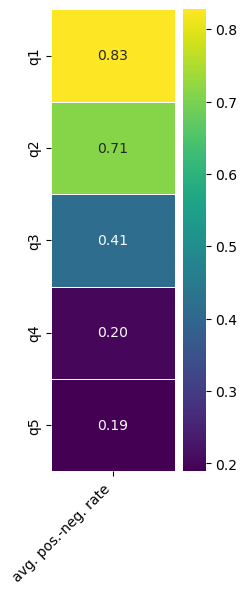

In [40]:
plt.figure(figsize=(2, 6))
heatmap = sns.heatmap(df_q_1_to_5_c, cmap='viridis', annot=True, fmt='.2f', linewidths=.5)
heatmap.set_xticklabels(heatmap.get_xticklabels(), rotation=45, ha='right')

## How are answers distributed for substitution tuples?

In [61]:
answers_per_recipe_sub_pair = {}

for recipe in recipes_with_answers:
    key = (recipe["sample_sub"][0], recipe["sample_sub"][1])
    if key not in answers_per_recipe_sub_pair.keys():
        answers_per_recipe_sub_pair[key] = {}
    consensual_answers = recipe['consensual_answers']
    for question, consensual_answer in list(consensual_answers.items()):
        if question not in answers_per_recipe_sub_pair[key].keys():
            answers_per_recipe_sub_pair[key][question] = []
        answers_per_recipe_sub_pair[key][question].append(consensual_answer)

print("done")

done


### create a dictionary and dataframe for answers per substitution tuple

In [62]:
binary_questions = ['fit', 'tastechange', 'nutruientschange', 'processchange', 'categorychange']
n_expected_answers = 10

answer_counts_per_sub_tuple = {}
for sub_tuple, answers_per_question in list(answers_per_recipe_sub_pair.items()):
    answer_counts_per_sub_tuple[sub_tuple] = {}
    for question, answers in list(answers_per_question.items()):
        if question not in binary_questions:
            continue
        n_no_consensus = len([answer for answer in answers if answer is None])
        n_consensus_positive = len([answer for answer in answers if answer == 1])
        n_consensus_negative = len([answer for answer in answers if answer == 0])
        answer_counts_per_sub_tuple[sub_tuple][question] = {}
        answer_counts_per_sub_tuple[sub_tuple][question]["consensus_positive"] = n_consensus_positive
        answer_counts_per_sub_tuple[sub_tuple][question]["consensus_negative"] = n_consensus_negative
        answer_counts_per_sub_tuple[sub_tuple][question]["no_consensus"] = n_no_consensus

#print(list(answer_counts_per_sub_tuple.values())[0])

In [63]:
df_a_per_sub_tup = pd.DataFrame(answer_counts_per_sub_tuple)

# print(df_a_per_sub_tup.shape)
# print(df_a_per_sub_tup.head(2))

In [64]:
binary_questions = ['fit', 'tastechange', 'nutruientschange', 'processchange', 'categorychange']
avg_answ_per_sub_tuple = {question: {"consensus_positive": 0, "consensus_negative": 0, "no_consensus": 0} for question in binary_questions}
for sub_tuple, questions in answer_counts_per_sub_tuple.items():
    for question, answer in questions.items():
        for answer, value in answer.items():
            avg_answ_per_sub_tuple[question][answer] += value

for question, answers in list(avg_answ_per_sub_tuple.items()):
    for answer, value in answers.items():
        avg_answ_per_sub_tuple[question][answer] = value / len(list(answer_counts_per_sub_tuple.keys()))

print("Average number of results per substitution tuple:")
for question, answers in avg_answ_per_sub_tuple.items():
    print(f"Question: {question}")
    for answer, value in answers.items():
        print(f"    Answer: {answer} - average count: {value}")


Average number of results per substitution tuple:
Question: fit
    Answer: consensus_positive - average count: 8.68
    Answer: consensus_negative - average count: 0.58
    Answer: no_consensus - average count: 0.74
Question: tastechange
    Answer: consensus_positive - average count: 7.66
    Answer: consensus_negative - average count: 0.48
    Answer: no_consensus - average count: 1.86
Question: nutruientschange
    Answer: consensus_positive - average count: 0.16
    Answer: consensus_negative - average count: 0.42
    Answer: no_consensus - average count: 9.42
Question: processchange
    Answer: consensus_positive - average count: 1.78
    Answer: consensus_negative - average count: 6.9
    Answer: no_consensus - average count: 1.32
Question: categorychange
    Answer: consensus_positive - average count: 1.6
    Answer: consensus_negative - average count: 7.22
    Answer: no_consensus - average count: 1.18


In [24]:
binary_questions = ['fit', 'tastechange', 'nutruientschange', 'processchange', 'categorychange']
n_expected_answers = 10

answer_counts_per_sub_tuple_ = {question: {"consensus_positive": {}, "consensus_negative": {}, "no_consensus": {}} for question in binary_questions}
for sub_tuple, answers_per_question in list(answers_per_recipe_sub_pair.items()):
    for question, answers in list(answers_per_question.items()):
        if question not in binary_questions:
            continue
        n_consensus_positive = len([answer for answer in answers if answer == 1])
        n_consensus_negative = len([answer for answer in answers if answer == 0])
        n_no_consensus = len([answer for answer in answers if answer is None])
        answer_counts_per_sub_tuple_[question]["consensus_positive"][sub_tuple] = n_consensus_positive
        answer_counts_per_sub_tuple_[question]["consensus_negative"][sub_tuple] = n_consensus_negative
        answer_counts_per_sub_tuple_[question]["no_consensus"][sub_tuple] = n_no_consensus


In [25]:
df_q_a_sub_tup = pd.DataFrame(answer_counts_per_sub_tuple_)

In [26]:
print(df_q_a_sub_tup.index)
print(df_q_a_sub_tup.columns)
print(df_q_a_sub_tup.head(2))

Index(['consensus_positive', 'consensus_negative', 'no_consensus'], dtype='object')
Index(['fit', 'tastechange', 'nutruientschange', 'processchange',
       'categorychange'],
      dtype='object')
                                                                  fit  \
consensus_positive  {('white_wine', 'white_wine_vinegar'): 10, ('t...   
consensus_negative  {('white_wine', 'white_wine_vinegar'): 0, ('to...   

                                                          tastechange  \
consensus_positive  {('white_wine', 'white_wine_vinegar'): 3, ('to...   
consensus_negative  {('white_wine', 'white_wine_vinegar'): 2, ('to...   

                                                     nutruientschange  \
consensus_positive  {('white_wine', 'white_wine_vinegar'): 0, ('to...   
consensus_negative  {('white_wine', 'white_wine_vinegar'): 1, ('to...   

                                                        processchange  \
consensus_positive  {('white_wine', 'white_wine_vinegar'): 0, ('to...